# 🎲 Transpilation Overview

**Transpilation** is transformation of given virtual quantum circuit:
- to match the topology of a specific device
- to optimize the circuit for execution

Six stages of transpilation:

1) **Init** - Unrolling custom instructions and converting the circuit to all 1 and 2 qubit gates.

2) **Layout** - Mapping circuit virtual qubits to backend physical qubits.

3) **Routing** - Inject SWAP gates to comply with the backend’s coupling map.

4) **Translation** - Translate to the target backend’s basis gate set.

5) **Optimization** - Main optimization loop to increase circuit quality.

6) **Scheduling** - Conversion to hardware-specific pulses.

In [1]:
# https://qiskit.org/documentation/apidoc/transpiler.html

### Layout and Routing

Placement of “virtual” qubits to “physical” qubits on coupling map of quantum device or simulator.

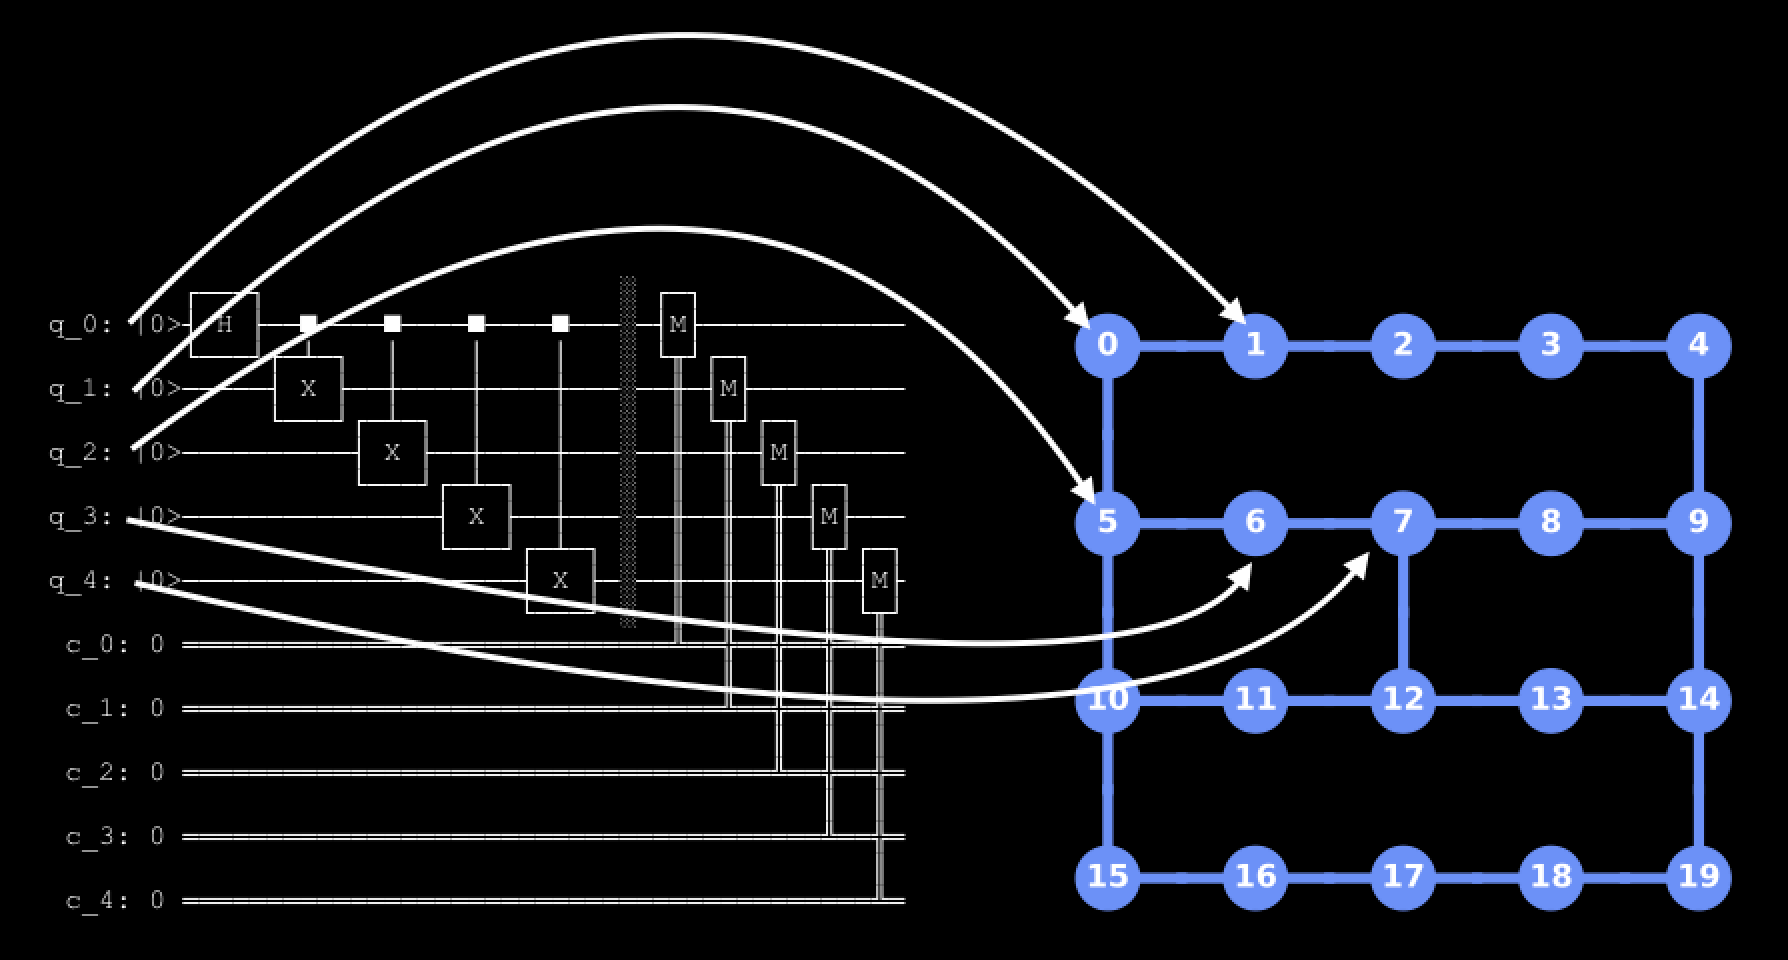

# 🎱 Transpilation Examples

In [2]:
import qiskit

from qiskit.providers.aer import AerSimulator

from qiskit.providers.fake_provider import FakeBackend5QV2
from qiskit.providers.fake_provider import FakeLimaV2
from qiskit.providers.fake_provider import FakeMontrealV2
from qiskit.providers.fake_provider import FakeGuadalupeV2
from qiskit.providers.fake_provider import FakeBoeblingenV2

In [3]:
import numpy as np

from tqdm import tqdm

from matplotlib import pyplot as plt

plt.style.use("dark_background")
    
%run transpiler_use_cases_backend.ipynb

In [4]:
%cd ../..

# Transpile Functions

from qml_transpiler import transpile
from qml_transpiler import transpile_chain
from qml_transpiler import transpile_right
from qml_transpiler import transpile_left
from qml_transpiler import transpile_and_compress

# Service Functions

from qml_transpiler import get_full_map
from qml_transpiler import get_ibm_cost
from qml_transpiler import get_circuit_hash

from qml_transpiler import get_cnot_circuit
from qml_transpiler import get_litmus_circuit

/mnt/c/Users/mohor/Jupyter/Haiqu/transpiler


### Litmus Circuit

In [5]:
QUBITS_COUNT = 3

litmus_circuit = get_litmus_circuit(QUBITS_COUNT, "Litmus")

litmus_circuit.draw()

┌──────────────┐          ┌───┐ Litmus 
Litmus_0_0: ┤ Rz(Litmus_0) ├──■───────┤ X ├───░────
            ├──────────────┤┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(Litmus_1) ├┤ X ├──■────┼─────░────
            ├──────────────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(Litmus_2) ├─────┤ X ├──■─────░────
            └──────────────┘     └───┘        ░

### Backend

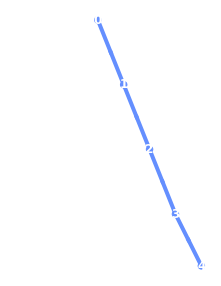

In [6]:
# Backend

FAKE_BACKEND = FakeBackend5QV2()
# FAKE_BACKEND = FakeLimaV2()
# FAKE_BACKEND = FakeGuadalupeV2()
# FAKE_BACKEND = FakeBoeblingenV2()
# FAKE_BACKEND = FakeMontrealV2()

backend = qiskit.providers.aer.AerSimulator.from_backend(FAKE_BACKEND)

backend.options.noise_model = None

qiskit.visualization.plot_gate_map(FAKE_BACKEND)

### Qiskit Transpile

In [7]:
transpiled_circuit = qiskit.transpile(
    litmus_circuit, 
    backend,
    seed_transpiler=1234,
    initial_layout=[0, 1, 2]
    # initial_layout=[0, 2, 4]
)

transpiled_circuit.draw()

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                ┌─────────────────┐               ┌───┐           ░ 
Litmus_0_0 -> 0 ┤ U(0,0,Litmus_0) ├──■─────────■──┤ X ├──■────────░─
                ├─────────────────┤┌─┴─┐     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐ ░ 
Litmus_0_1 -> 1 ┤ U(0,0,Litmus_1) ├┤ X ├──■──┤ X ├──■──┤ X ├┤ X ├─░─
                ├─────────────────┤└───┘┌─┴─┐└───┘     └───┘└─┬─┘ ░ 
Litmus_0_2 -> 2 ┤ U(0,0,Litmus_2) ├─────┤ X ├─────────────────■───░─
                └─────────────────┘     └───┘                     ░ 
 ancilla_0 -> 3 ──────────────────────────────────────────────────░─
                                                                  ░ 
 ancilla_1 -> 4 ──────────────────────────────────────────────────░─
                                                                  ░

Final qubit allocation after transpilation:

In [8]:
get_full_map(transpiled_circuit)

[1, 0, 2, 3, 4]

Example of qubit allocation during transpilation:

- `Zero Map` - Ancillas added
- `After Layout` - Initial layout applied 
- `After Routing` - SWAPs applied 
- `Full Map` - Final qubit allocation 

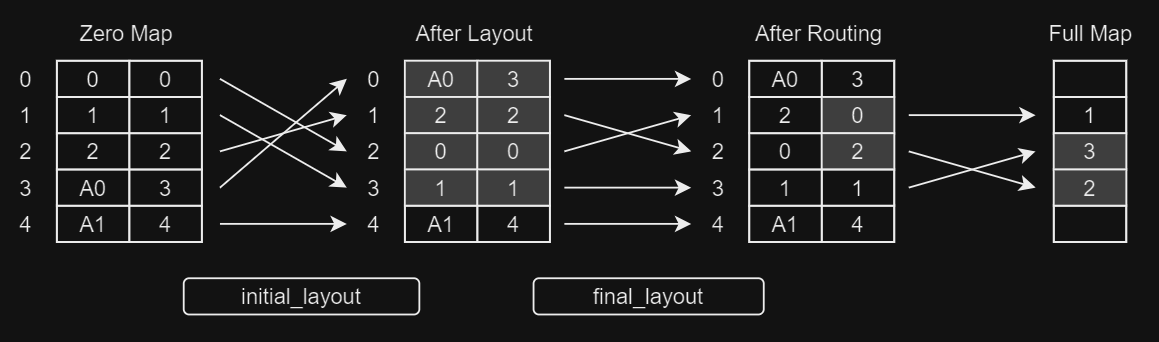

### Our Transpile

In [9]:
transpiled_circuit = transpile(
    litmus_circuit, 
    backend,
    seed_transpiler=1234,
    # initial_layout=[0, 1, 2]
    # initial_layout=[0, 2, 4]
)

transpiled_circuit.draw()

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

### Transpile Chain

In [10]:
CHAIN = [litmus_circuit] * 5

transpiled_chain_circuit = transpile_chain(
    CHAIN, 
    backend,
    seed_transpiler=1234,
    initial_layout=[0, 1, 2]
    # initial_layout=[0, 2, 4]
)

transpiled_chain_circuit.draw(fold=-1)

global phase: -2.5*Litmus_0 - 2.5*Litmus_1 - 2.5*Litmus_2
                ┌─────────────────┐               ┌───┐           ░ ┌─────────────────┐┌───┐                          ░ ┌─────────────────┐     ┌───┐          ┌───┐     ┌───┐           ░ ┌─────────────────┐     ┌───┐          ┌───┐     ┌───┐           ░ ┌─────────────────┐     ┌───┐          ┌───┐     ┌───┐           ░ 
Litmus_0_1 -> 0 ┤ U(0,0,Litmus_0) ├──■─────────■──┤ X ├──■────────░─┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─┤ U(0,0,Litmus_1) ├──■──┤ X ├──■───────┤ X ├──■──┤ X ├──■────────░─┤ U(0,0,Litmus_1) ├──■──┤ X ├──■───────┤ X ├──■──┤ X ├──■────────░─┤ U(0,0,Litmus_1) ├──■──┤ X ├──■───────┤ X ├──■──┤ X ├──■────────░─
                ├─────────────────┤┌─┴─┐     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐ ░ ├─────────────────┤└─┬─┘┌───┐     ┌───┐┌─┴─┐      ░ ├─────────────────┤┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘┌─┴─┐└─┬─┘┌─┴─┐      ░ ├─────────────────┤┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘┌─┴─┐└─┬─┘┌─┴─┐      ░ ├─────────────────┤┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘┌─┴─┐└─┬─┘┌─┴─┐      ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_1) ├┤ X ├──■──┤ X ├──■──┤ X ├┤ X ├─░─┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─┤ U(0,0,Litmus_2) ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■──┤ X ├──■───░─┤ U(0,0,Litmus_2) ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■──┤ X ├──■───░─┤ U(0,0,Litmus_2) ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■──┤ X ├──■───░─
                ├─────────────────┤└───┘┌─┴─┐└───┘     └───┘└─┬─┘ ░ ├─────────────────┤     └─┬─┘┌─┴─┐└─┬─┘└───┘┌─┴─┐ ░ ├─────────────────┤└───┘     └───┘└─┬─┘     └───┘     └───┘┌─┴─┐ ░ ├─────────────────┤└───┘     └───┘└─┬─┘     └───┘     └───┘┌─┴─┐ ░ ├─────────────────┤└───┘     └───┘└─┬─┘     └───┘     └───┘┌─┴─┐ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_2) ├─────┤ X ├─────────────────■───░─┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─┤ U(0,0,Litmus_0) ├─────────────────■──────────────────────┤ X ├─░─┤ U(0,0,Litmus_0) ├─────────────────■──────────────────────┤ X ├─░─┤ U(0,0,Litmus_0) ├─────────────────■──────────────────────┤ X ├─░─
                └─────────────────┘     └───┘                     ░ └─────────────────┘          └───┘          └───┘ ░ └─────────────────┘                                        └───┘ ░ └─────────────────┘                                        └───┘ ░ └─────────────────┘                                        └───┘ ░ 
 ancilla_0 -> 3 ──────────────────────────────────────────────────░───────────────────────────────────────────────────░──────────────────────────────────────────────────────────────────░──────────────────────────────────────────────────────────────────░──────────────────────────────────────────────────────────────────░─
                                                                  ░                                                   ░                                                                  ░                                                                  ░                                                                  ░ 
 ancilla_1 -> 4 ──────────────────────────────────────────────────░───────────────────────────────────────────────────░──────────────────────────────────────────────────────────────────░──────────────────────────────────────────────────────────────────░──────────────────────────────────────────────────────────────────░─
                                                                  ░                                                   ░                                                                  ░                                                                  ░                                                                  ░

In [11]:
get_full_map(transpiled_chain_circuit)

[2, 0, 1, 3, 4]

### Transpile Right

In [12]:
transpiled_circuit.draw()

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

In [13]:
cnot_circuit = get_cnot_circuit(QUBITS_COUNT, "CNOT", [0, 1])

cnot_circuit.draw()

┌────────────┐      CNOT 
CNOT_0_0: ┤ Rz(CNOT_0) ├──■────░───
          ├────────────┤┌─┴─┐  ░   
CNOT_0_1: ┤ Rz(CNOT_1) ├┤ X ├──░───
          ├────────────┤└───┘  ░   
CNOT_0_2: ┤ Rz(CNOT_2) ├───────░───
          └────────────┘       ░

In [14]:
transpiled_right_circuit = transpile_right(
    central_circuit=transpiled_circuit,
    right_circuit=cnot_circuit,
    backend=backend,
    seed_transpiler=1234
)

transpiled_right_circuit.draw(fold=-1)

global phase: -0.5*CNOT_0 - 0.5*CNOT_1 - 0.5*CNOT_2 - 0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                                                          ░ 
 ancilla_0 -> 0 ──────────────────────────────────────────────────────────────────────────────────────────░─
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ ┌───────────────┐                     ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─┤ U(0,0,CNOT_0) ├─────────────────■───░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ ├───────────────┤┌───┐     ┌───┐┌─┴─┐ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─┤ U(0,0,CNOT_2) ├┤ X ├──■──┤ X ├┤ X ├─░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ ├───────────────┤└─┬─┘┌─┴─┐└─┬─┘└───┘ ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─┤ U(0,0,CNOT_1) ├──■──┤ X ├──■────────░─
                └─────────────────┘└───┘                          ░ └───────────────┘     └───┘           ░ 
 ancilla_1 -> 4 ──────────────────────────────────────────────────────────────────────────────────────────░─
                                                                                                          ░

In [15]:
transpiled_right_circuit = transpile_right(
    central_circuit=transpiled_right_circuit,
    right_circuit=cnot_circuit,
    backend=backend,
    seed_transpiler=1234,
)

transpiled_right_circuit.draw(fold=-1)

global phase: -1.0*CNOT_0 - 1.0*CNOT_1 - 1.0*CNOT_2 - 0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                                                          ░                             
 ancilla_0 -> 0 ──────────────────────────────────────────────────────────────────────────────────────────░─────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ ┌───────────────┐                     ░ ┌───────────────┐      CNOT 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─┤ U(0,0,CNOT_0) ├─────────────────■───░─┤ U(0,0,CNOT_0) ├──■────░───
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ ├───────────────┤┌───┐     ┌───┐┌─┴─┐ ░ ├───────────────┤┌─┴─┐  ░   
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─┤ U(0,0,CNOT_2) ├┤ X ├──■──┤ X ├┤ X ├─░─┤ U(0,0,CNOT_1) ├┤ X ├──░───
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ ├───────────────┤└─┬─┘┌─┴─┐└─┬─┘└───┘ ░ ├───────────────┤└───┘  ░   
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─┤ U(0,0,CNOT_1) ├──■──┤ X ├──■────────░─┤ U(0,0,CNOT_2) ├───────░───
                └─────────────────┘└───┘                          ░ └───────────────┘     └───┘           ░ └───────────────┘       ░   
 ancilla_1 -> 4 ──────────────────────────────────────────────────────────────────────────────────────────░─────────────────────────────
                                                                                                          ░

### Transpile Left

In [16]:
transpiled_left_circuit = transpile_left(
    central_circuit=transpiled_circuit,
    left_circuit=cnot_circuit,
    backend=backend,
    seed_transpiler=1234
)

transpiled_left_circuit.draw(fold=-1)

global phase: -0.5*CNOT_0 - 0.5*CNOT_1 - 0.5*CNOT_2 - 0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                                                
ancilla_0 -> 0 ─────────────────────────────────────────────────────────────────────────────────
               ┌───────────────────┐      ░ ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
 CNOT_0_2 -> 1 ┤ U(0,1.0*CNOT_2,0) ├──────░─┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
               ├───────────────────┤      ░ ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
 CNOT_0_0 -> 2 ┤ U(0,1.0*CNOT_0,0) ├──■───░─┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
               ├───────────────────┤┌─┴─┐ ░ ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
 CNOT_0_1 -> 3 ┤ U(0,1.0*CNOT_1,0) ├┤ X ├─░─┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
               └───────────────────┘└───┘ ░ └─────────────────┘└───┘                          ░ 
ancilla_1 -> 4 ─────────────────────────────────────────────────────────────────────────────────

In [17]:
transpiled_left_circuit = transpile_left(
    central_circuit=transpiled_left_circuit,
    left_circuit=litmus_circuit,
    backend=backend,
    seed_transpiler=1234
)

transpiled_left_circuit.draw(fold=-1)

global phase: -0.5*CNOT_0 - 0.5*CNOT_1 - 0.5*CNOT_2 - 1.0*Litmus_0 - 1.0*Litmus_1 - 1.0*Litmus_2
                                                                                                                                                         
 ancilla_0 -> 0 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                ┌─────────────────────┐     ┌───┐                     ░ ┌───────────────────┐      ░ ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,1.0*Litmus_2,0) ├─────┤ X ├─────────────────■───░─┤ U(0,1.0*CNOT_2,0) ├──────░─┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────────┤┌───┐└─┬─┘┌───┐     ┌───┐┌─┴─┐ ░ ├───────────────────┤      ░ ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_1 -> 2 ┤ U(0,1.0*Litmus_1,0) ├┤ X ├──■──┤ X ├──■──┤ X ├┤ X ├─░─┤ U(0,1.0*CNOT_0,0) ├──■───░─┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────────┤└─┬─┘     └─┬─┘┌─┴─┐└─┬─┘└───┘ ░ ├───────────────────┤┌─┴─┐ ░ ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_0 -> 3 ┤ U(0,1.0*Litmus_0,0) ├──■─────────■──┤ X ├──■────────░─┤ U(0,1.0*CNOT_1,0) ├┤ X ├─░─┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────────┘               └───┘           ░ └───────────────────┘└───┘ ░ └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

### Transpile and Compress

`transpile_and_compress` function allows to avoid using unnecessary ancilla qubits.

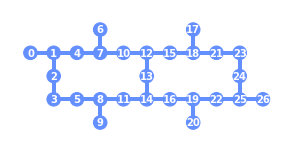

In [18]:
FAKE_BACKEND = FakeMontrealV2()

backend = qiskit.providers.aer.AerSimulator.from_backend(FAKE_BACKEND)

backend.options.noise_model = None

qiskit.visualization.plot_gate_map(FAKE_BACKEND)

In [19]:
transpiled_litmus_circuit = transpile(
    litmus_circuit, 
    backend,
    optimization_level=3,
    routing_method='lookahead',
    seed_transpiler=1234,
)

transpiled_litmus_circuit.draw(idle_wires=False)

┌───┐                          ░ 
 ancilla_13 -> 5 ───────■────────┤ X ├──■───────────────────────░─
                      ┌─┴─┐      └─┬─┘┌─┴─┐                     ░ 
 ancilla_14 -> 8 ─────┤ X ├────────■──┤ X ├─────────────────────░─
                 ┌────┴───┴─────┐┌───┐└───┘                     ░ 
Litmus_0_1 -> 11 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■────────░─
                 ├──────────────┤└─┬─┘┌───┐     ┌───┐  │  ┌───┐ ░ 
Litmus_0_2 -> 13 ┤ Rz(Litmus_2) ├──┼──┤ X ├──■──┤ X ├──┼──┤ X ├─░─
                 ├──────────────┤  │  └─┬─┘┌─┴─┐└─┬─┘┌─┴─┐└─┬─┘ ░ 
Litmus_0_0 -> 14 ┤ Rz(Litmus_0) ├──■────■──┤ X ├──■──┤ X ├──■───░─
                 └──────────────┘          └───┘     └───┘      ░

In [20]:
compressed_circuit = transpile_and_compress(
    litmus_circuit, 
    backend=backend,
    optimization_level=3,
    routing_method='lookahead',
    seed_transpiler=1234,
)

compressed_circuit.draw(idle_wires=False)

┌──────────────┐          ┌───┐          ┌───┐ ░  ░ 
Litmus_0_2 -> 12 ┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░──░─
                 ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░  ░ 
Litmus_0_0 -> 13 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░────
                 ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░  ░ 
Litmus_0_1 -> 14 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■────────░──░─
                 └──────────────┘└───┘                          ░  ░

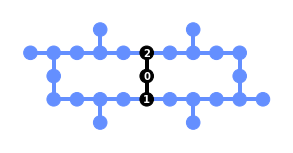

In [21]:
qiskit.visualization.plot_circuit_layout(compressed_circuit, FAKE_BACKEND)

`transpile_and_compress` selects topologically most important qubits of a backend
to produce limited coupling map - to decrease transpilation and simulation time:

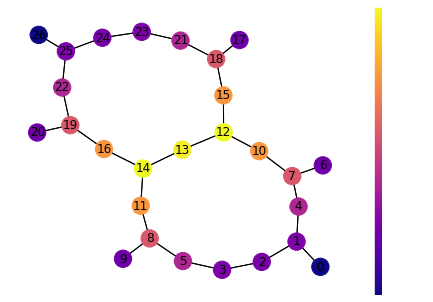

We use flexible measure of node importance - node “closeness centrality” in backend topology graph.

Closeness centrality is efficiently calculated using “rustworkx” graph library function:

https://qiskit.org/ecosystem/rustworkx/dev/apiref/rustworkx.closeness_centrality.html

Flexible measure of node importance can be expanded with other metrics -
for example, neighbors counts or qubit noise levels.

Once importances are calculated - we traverse topology graph using A-star search -
starting from the most important node.

Traversed nodes are added to limited qubit list - which forms a connected subgraph.

Discovered subgraph is used to limit backend topology during transpilation.

### Stacks

Pre-defined transpilation stacks to use:

- Qiskit transpilation
- Pytket transpilation
- BQSKit QSearch synthesis
- BQSKit QFactor instantiation

In [22]:
STACKS = ["qiskit",
          "qiskit_qsearch",
          "qiskit_qfactor_qsearch",
          "qiskit_pytket"]

In [23]:
# Backend

FAKE_BACKEND = FakeBackend5QV2()

backend = qiskit.providers.aer.AerSimulator.from_backend(FAKE_BACKEND)

backend.options.noise_model = None

# qiskit.visualization.plot_gate_map(FAKE_BACKEND)

#### Qiskit

In [24]:
transpiled_circuit = transpile(
    litmus_circuit,
    backend,
    stack="qiskit",
    seed_transpiler=1234)

transpiled_circuit.draw()    

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

#### Pytket

In [25]:
transpiled_circuit = transpile(
    litmus_circuit,
    backend,
    stack="qiskit_pytket",
    seed_transpiler=1234)

transpiled_circuit.draw()    

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

#### QSearch

In [26]:
# Bind Circuit Parameters

bound_litmus_circuit = litmus_circuit.copy()

for index, parameter in enumerate(litmus_circuit.parameters):
    
    bound_litmus_circuit.assign_parameters(
        {parameter: index}, 
        inplace=True)

In [27]:
transpiled_circuit = transpile(
    bound_litmus_circuit,
    backend,
    stack="qiskit_qsearch",
    qsearch_block_size=2,
    seed_transpiler=1234)

transpiled_circuit.draw(fold=-1)    

global phase: 4.4099
                                                                                                                                      
ancilla_0 -> 0 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                  ┌─────────────────┐                             ┌───┐                               
      q_0 -> 1 ────────────────────────────■──────┤ U(π/2,2.7245,π) ├──────────────────■──────────┤ X ├──■────────────────────────────
               ┌────────────────────────┐┌─┴─┐┌───┴─────────────────┴───┐            ┌─┴─┐        └─┬─┘┌─┴─┐      ┌──────────────────┐
      q_1 -> 2 ┤ U(9.4248,4.496,2.3544) ├┤ X ├┤ U(9.4248,1.2872,4.4288) ├──■─────────┤ X ├──────────■──┤ X ├──■───┤ U(3π/2,π,6.7003) ├
               └┬──────────────────────┬┘└───┘└─────────────────────────┘┌─┴─┐┌──────┴───┴───────┐     └───┘┌─┴─┐┌┴──────────────────┤
      q_2 -> 3 ─┤ U(π,-0.43846,4.7031) ├─────────────────────────────────┤ X ├┤ U(π/2,0,-1.8298) ├──────────┤ X ├┤ U(3π/2,-1.8298,π) ├
                └──────────────────────┘                                 └───┘└──────────────────┘          └───┘└───────────────────┘
ancilla_1 -> 4 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

#### QFactor + QSearch

In [28]:
transpiled_circuit = transpile(
    bound_litmus_circuit,
    backend,
    stack="qiskit_qfactor_qsearch",
    qsearch_block_size=2,
    seed_transpiler=1234)

transpiled_circuit.draw(fold=-1)   

global phase: 0.82617
                                                                                                                                                                               
ancilla_0 -> 0 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               ┌─────────────────┐                                                              ┌───┐┌────────────────────────────┐               ┌───┐┌──────────────────────┐
      q_2 -> 1 ┤ U(π/2,π,4.8071) ├──────────────────────────────────────────────────────────────┤ X ├┤ U(1.7278,0.29656,-0.47286) ├───────────────┤ X ├┤ U(0.49636,-π/2,5π/2) ├
               └─────────────────┘┌─────────────────────────┐      ┌───────────────────────────┐└─┬─┘└───┬────────────────────┬───┘┌───┐     ┌───┐└─┬─┘└──────────────────────┘
      q_0 -> 2 ─────────■─────────┤ U(4.7124,4.3171,3.1416) ├───■──┤ U(2.1416,-1.1283,0.39526) ├──■──────┤ U(-π/2,π,-0.44249) ├────┤ X ├──■──┤ X ├──■──────────────────────────
                      ┌─┴─┐       ├─────────────────────────┴┐┌─┴─┐└────┬─────────────────┬────┘         └────────────────────┘    └─┬─┘┌─┴─┐└─┬─┘                             
      q_1 -> 3 ───────┤ X ├───────┤ U(1.5708,-9.4248,17.376) ├┤ X ├─────┤ U(π/2,1.4735,0) ├──────────────────────────────────────────■──┤ X ├──■───────────────────────────────
                      └───┘       └──────────────────────────┘└───┘     └─────────────────┘                                             └───┘                                  
ancilla_1 -> 4 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

#### Synthesis

**Quantum circuit synthesis** is the process of converting a mathematical description of a quantum transformation - often given as a unitary matrix - into a circuit composed of gates from a fixed gate set.

**Search-based** class of synthesis tools is categorized by the discrete search for a desired circuit through a space of circuits. These techniques are usually bottom-up, they start with an empty circuit and grow out as they search through the space.

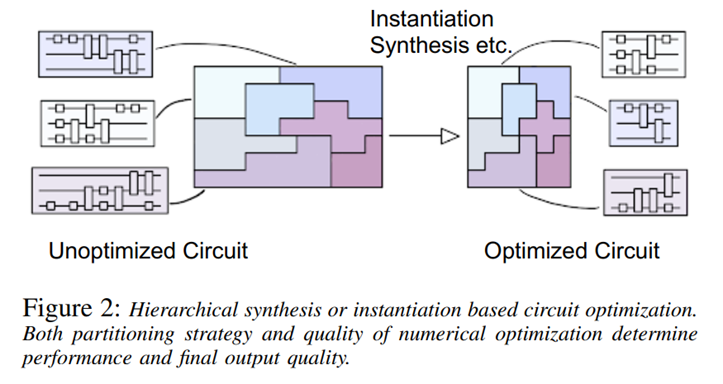

[1] QFactor: A Domain-Specific Optimizer for Quantum Circuit Instantiation – https://arxiv.org/pdf/2306.08152.pdf

#### QSearch

**QSearch** is a powerful search-based synthesis tool, which phrases the problem of circuit synthesis as a search over circuit structures combined with numerical optimization to instantiate circuit parameters.

1) The algorithm starts by placing single-qubit rotations on all qubits. 

2) The circuit is then instantiated by calling a numerical optimization subroutine to solve for the gate's parameters that minimize the distance between the circuit's unitary and the target unitary. 

3) After this, fixed building blocks composed of two-qubit gates followed by single-qubit rotations are placed on all pairs of qubits. 

This branching pattern forms the circuit tree, where at depth n in the tree, all possible circuit structures with n two-qudit gates exist. 

Each structure is a candidate solution is evaluated using the same numerical optimization process, and the order of evaluations is determined by A* search.

### Circuit Hash

Calculates SHA256 hash for given quantum circuit.

Hash is based on properties of circuit gates:

- Instruction class (RX, CNOT, CRZ, etc.)
- Parameter values (angles)
- Used qubits
- Used classical bits

Parameter names are ignored - circuits with not-bound RZ("theta_1") and RZ("theta_2") will have equal hashes.

Inspired by Qiskit `soft_compare` gate function:

https://github.com/Qiskit/qiskit/blob/main/qiskit/circuit/instruction.py#L227

In [29]:
get_circuit_hash(litmus_circuit)

'aa1bfa5282974640ae1261fdf6a2fc082c977857a8a5b9e1270ff10db6ee72c9'

In [30]:
get_circuit_hash(transpiled_circuit)

'839e50ac170a76e84cbf3e6c89df2a4207eb247942a142d708f27f774acae7ed'

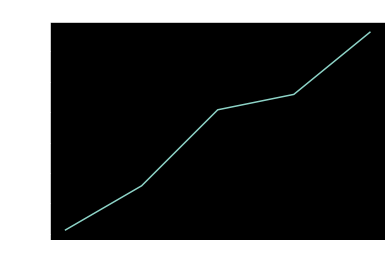

### IBM Cost

IBM Cost is a product of gate fidelities (F) and depth penalization (K):

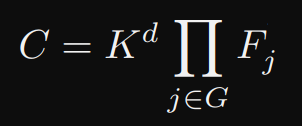

* K - circuit depth penalization factor
* d - circuit depth
* G - gates
* F - fidelities

IBM Cost can be used as circuit quality metric.

[1] “Demonstration of quantum volume 64 on a superconducting quantum computing system” – IBMQ – P. Jurcevic, A. Javadi-Abhari, L. S. Bishop and others – https://arxiv.org/abs/2008.08571

In [31]:
litmus_circuit.draw()

┌──────────────┐          ┌───┐ Litmus 
Litmus_0_0: ┤ Rz(Litmus_0) ├──■───────┤ X ├───░────
            ├──────────────┤┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(Litmus_1) ├┤ X ├──■────┼─────░────
            ├──────────────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(Litmus_2) ├─────┤ X ├──■─────░────
            └──────────────┘     └───┘        ░

In [32]:
get_ibm_cost(litmus_circuit)

0.9498972910479807

In [33]:
transpiled_circuit.draw(fold=-1)

global phase: 0.82617
                                                                                                                                                                               
ancilla_0 -> 0 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               ┌─────────────────┐                                                              ┌───┐┌────────────────────────────┐               ┌───┐┌──────────────────────┐
      q_2 -> 1 ┤ U(π/2,π,4.8071) ├──────────────────────────────────────────────────────────────┤ X ├┤ U(1.7278,0.29656,-0.47286) ├───────────────┤ X ├┤ U(0.49636,-π/2,5π/2) ├
               └─────────────────┘┌─────────────────────────┐      ┌───────────────────────────┐└─┬─┘└───┬────────────────────┬───┘┌───┐     ┌───┐└─┬─┘└──────────────────────┘
      q_0 -> 2 ─────────■─────────┤ U(4.7124,4.3171,3.1416) ├───■──┤ U(2.1416,-1.1283,0.39526) ├──■──────┤ U(-π/2,π,-0.44249) ├────┤ X ├──■──┤ X ├──■──────────────────────────
                      ┌─┴─┐       ├─────────────────────────┴┐┌─┴─┐└────┬─────────────────┬────┘         └────────────────────┘    └─┬─┘┌─┴─┐└─┬─┘                             
      q_1 -> 3 ───────┤ X ├───────┤ U(1.5708,-9.4248,17.376) ├┤ X ├─────┤ U(π/2,1.4735,0) ├──────────────────────────────────────────■──┤ X ├──■───────────────────────────────
                      └───┘       └──────────────────────────┘└───┘     └─────────────────┘                                             └───┘                                  
ancilla_1 -> 4 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [34]:
get_ibm_cost(transpiled_circuit)

0.8792456533713967

#  ♟ Transpilation Use Cases

## 1) Transpile Right - Shadow State Tomography

In [35]:
# https://github.com/ryanlevy/shadow-tutorial/blob/main/Tutorial_Shadow_State_Tomography.ipynb

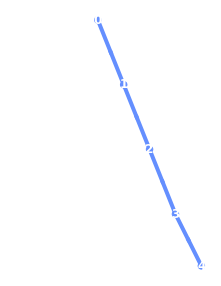

In [36]:
FAKE_BACKEND = FakeBackend5QV2()
# FAKE_BACKEND = FakeLimaV2()
# FAKE_BACKEND = FakeGuadalupeV2()
# FAKE_BACKEND = FakeBoeblingenV2()
# FAKE_BACKEND = FakeMontrealV2()

backend = AerSimulator.from_backend(FAKE_BACKEND)

backend.options.noise_model = None

qiskit.visualization.plot_gate_map(FAKE_BACKEND)

### Parameters

In [37]:
QUBITS_COUNT = 3
SU2_LAYERS_COUNT = 1

TOTAL_SHOTS_COUNT = 1000
OPTIMIZATION_LEVEL = 3
SEED = 1234

### SU2 Circuit

In [38]:
su2_circuit = qiskit.circuit.library.EfficientSU2(
    num_qubits=QUBITS_COUNT,
    reps=SU2_LAYERS_COUNT,
    entanglement="linear",
    skip_final_rotation_layer=True
)

parametrized_circuit = su2_circuit.decompose()

random_parameters = np.random.rand(parametrized_circuit.num_parameters)

circuit = parametrized_circuit.bind_parameters(random_parameters)

print("circuit.depth():", circuit.depth())

circuit.draw(fold=-1)

circuit.depth(): 4


┌─────────────┐┌─────────────┐          
q_0: ┤ Ry(0.76512) ├┤ Rz(0.76877) ├──■───────
     ├─────────────┤├─────────────┤┌─┴─┐     
q_1: ┤ Ry(0.48726) ├┤ Rz(0.95065) ├┤ X ├──■──
     ├─────────────┤├─────────────┤└───┘┌─┴─┐
q_2: ┤ Ry(0.59063) ├┤ Rz(0.47019) ├─────┤ X ├
     └─────────────┘└─────────────┘     └───┘

### Bases

In [39]:
rng = np.random.default_rng(SEED)

random_bases = rng.choice(['X','Y','Z'], size=(TOTAL_SHOTS_COUNT, QUBITS_COUNT))
          
bases_list, shots_counts = np.unique(random_bases, axis=0, return_counts=True)

bases_list.shape

(27, 3)

### Rotation Circuits

In [40]:
rotation_circuits = []

for bases in bases_list:
        
    rotation_circuit = build_bases_rotation_circuit(bases)
    
    rotation_circuits.append(rotation_circuit)

len(rotation_circuits)

27

In [41]:
rotation_circuits[3].draw()

┌───┐      
q_0: ─┤ H ├──────
     ┌┴───┴┐┌───┐
q_1: ┤ Sdg ├┤ H ├
     └┬───┬┘└───┘
q_2: ─┤ H ├──────
      └───┘

### Basic Transpilation - Slower one!

In [42]:
# Compose and Transpile all Rotation Circuits

shadow_circuits = []

rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:
    
    measurement_circuit = rotation_circuit.measure_all(inplace=False)
    
    measured_circuit = circuit.compose(measurement_circuit)
    
    # display(measured_circuit.draw(fold=-1))
    
    shadow_circuit = qiskit.transpile(
        measured_circuit, 
        backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)
    
    shadow_circuits.append(shadow_circuit)

100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 57.98 basis/s]


### Transpile Right - Much faster!

In [43]:
# Transpile Central Part

transpiled_central_circuit = qiskit.transpile(
    circuit, 
    backend,
    seed_transpiler=SEED,
    optimization_level=OPTIMIZATION_LEVEL)


# Transpile Right all Rotation Circuits

shadow_circuits = []
    
rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:
    
    measurement_circuit = rotation_circuit.measure_all(inplace=False)
    
    shadow_circuit = transpile_right(
        transpiled_central_circuit, 
        measurement_circuit,
        backend=backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)    
    
    shadow_circuits.append(shadow_circuit)

100%|████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 111.80 basis/s]


### Calculate Shadows

In [44]:
counts_list = run_shadow_circuits(shadow_circuits, backend, shots_counts)

shadows = get_shadows(bases_list, counts_list)

### Density Matrices

In [45]:
original_density_matrix = qiskit.quantum_info.DensityMatrix(circuit).data

reconstructed_density_matrix = np.sum(shadows, axis=0) / TOTAL_SHOTS_COUNT

### Plot Density Matrices

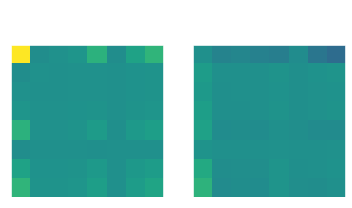

In [46]:
plot_density_matrix(original_density_matrix, label="Original")

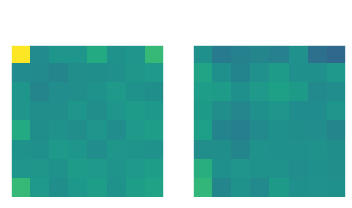

In [47]:
plot_density_matrix(reconstructed_density_matrix, label="Reconstructed")

### Mean Square Error

In [48]:
get_mean_square_error(original_density_matrix,
                      reconstructed_density_matrix)

0.00010086832756546362

### Benchmarking

For parametrized SU2 with depth 1000:

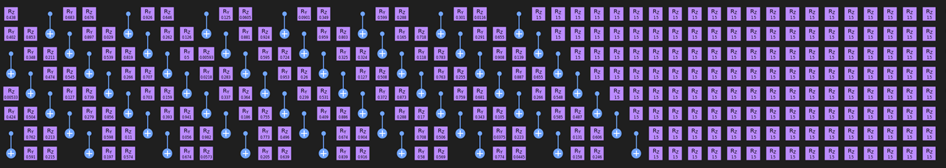

"Transpile Right" shows much better results than "Basic Transpilation":

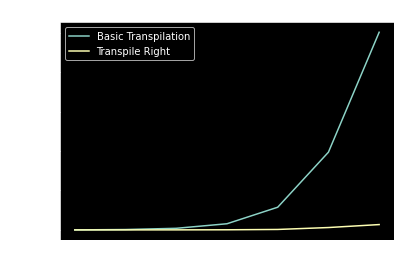

\* Transpilation time in milliseconds

## 2) Transpile Left - Quantum Fourier Transform

In [49]:
# https://github.com/SRI-International/QC-App-Oriented-Benchmarks/tree/master/quantum-fourier-transform

Fourier Adder:

- Initializes qubits with arbitrary bitstring
- Converts to Fourier basis
- Adds specified integer value in Fourier basis
- Converts back to measurement basis
- Measures initial state plus added integer

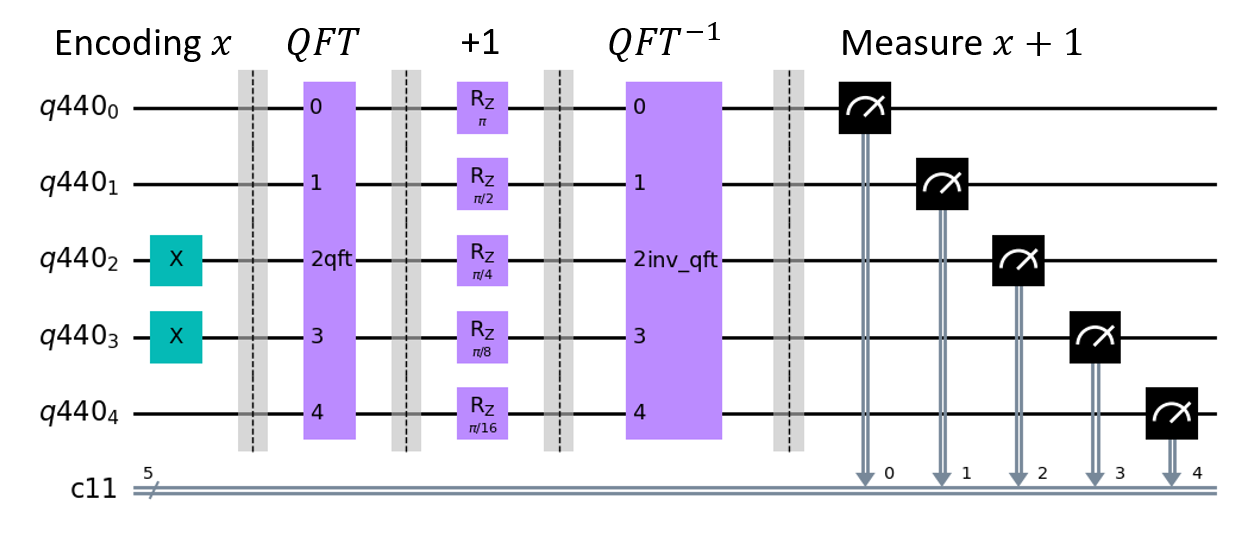

### Backend

In [50]:
# FAKE_BACKEND = FakeBackend5QV2()
# FAKE_BACKEND = FakeLimaV2()
# FAKE_BACKEND = FakeGuadalupeV2()
# FAKE_BACKEND = FakeBoeblingenV2()
FAKE_BACKEND = FakeMontrealV2()

backend = AerSimulator.from_backend(FAKE_BACKEND)

# backend.options.noise_model = None

# qiskit.visualization.plot_gate_map(FAKE_BACKEND)

### Parameters

In [51]:
QUBITS_COUNT = 5
NUMBER_TO_ADD = 2
EXPERIMENTS_COUNT = 10

OPTIMIZATION_LEVEL = 3
SHOTS_COUNT = 1000
SEED = 1234

### States

In [52]:
states_count = 2 ** QUBITS_COUNT

state_pattern = f">0{QUBITS_COUNT}b"

initial_states = [f"{state:{state_pattern}}" for state in range(EXPERIMENTS_COUNT)]

initial_states

['00000',
 '00001',
 '00010',
 '00011',
 '00100',
 '00101',
 '00110',
 '00111',
 '01000',
 '01001']

### Circuit Parts

In [53]:
qft_circuit = build_qft_circuit(QUBITS_COUNT)

inverted_qft_circuit = qft_circuit.inverse()
    
fourrier_adder = build_fourrier_adder(QUBITS_COUNT, NUMBER_TO_ADD)

### Basic Transpilation - Slower one!

In [54]:
# Compose and Transpile

transpiled_circuits = []

states_tracker = tqdm(initial_states, unit=' experiment', ncols=110)

for initial_state in states_tracker:
    
    state_circuit = build_state_circuit(initial_state)
    
    circuit = state_circuit.compose(qft_circuit)    
    circuit = circuit.compose(fourrier_adder)
    circuit = circuit.compose(inverted_qft_circuit)
    
    circuit.measure_all()
    
    # display(circuit.draw(fold=-1))
    
    transpiled_circuit = qiskit.transpile(
        circuit, 
        backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)
    
    transpiled_circuits.append(transpiled_circuit)

100%|████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41 experiment/s]


### Transpile Left - Much faster!

In [55]:
# Transpile Central Part

central_circuit = qft_circuit.compose(fourrier_adder)    
central_circuit = central_circuit.compose(inverted_qft_circuit)

central_circuit.measure_all()

transpiled_central_circuit = qiskit.transpile(
    central_circuit, 
    backend,
    seed_transpiler=SEED,
    optimization_level=OPTIMIZATION_LEVEL)

# transpiled_central_circuit.draw(idle_wires=False, fold=-1)

In [56]:
# Transpile Left

transpiled_circuits = []

states_tracker = tqdm(initial_states, unit=' experiment', ncols=110)

for initial_state in states_tracker:
    
    state_circuit = build_state_circuit(initial_state)
    
    transpiled_circuit = transpile_left(
        transpiled_central_circuit, 
        left_circuit=state_circuit,
        backend=backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)
    
    transpiled_circuits.append(transpiled_circuit)

100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 80.56 experiment/s]


### Run Circuits

In [57]:
counts_list = []

transpiled_circuit_tracker = tqdm(transpiled_circuits, unit=' circuit', ncols=110)

for transpiled_circuit in transpiled_circuit_tracker:

    job = backend.run(transpiled_circuit, shots=SHOTS_COUNT)

    counts = job.result().get_counts()

    counts_list.append(counts)

# counts_list

100%|███████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.62 circuit/s]


### Compare States

In [58]:
# Initial State Indices

initial_state_indices = [int(initial_state, 2) for initial_state in initial_states]

In [59]:
# Top State Indices

top_state_indices = []

for counts in counts_list:
    
    top_measured_state = max(counts, key=counts.get)
    
    top_state_index = int(top_measured_state, 2)
    
    top_state_indices.append(top_state_index)

In [60]:
# Check that Addition works

for initial_state_index, top_state_index in zip(initial_state_indices, 
                                                top_state_indices):
    
    assert top_state_index == (initial_state_index + NUMBER_TO_ADD) % states_count

In [61]:
# Global Counts

global_counts = np.zeros((EXPERIMENTS_COUNT, states_count), int)

for experiment, counts in enumerate(counts_list):
    
    for state, count in counts.items():
        
        state_index = int(state, 2)
        
        global_counts[experiment, state_index] = count

### Plots

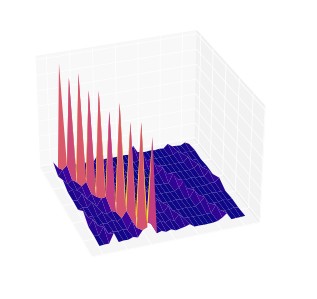

In [62]:
build_counts_figure(
    initial_states=range(EXPERIMENTS_COUNT),
    measured_states=range(states_count),
    counts=global_counts,
    elevation=30,
    initial_azimuth=160+180
)

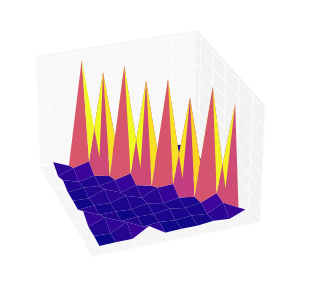

In [63]:
build_counts_figure(
    initial_states=range(EXPERIMENTS_COUNT),
    measured_states=range(EXPERIMENTS_COUNT),
    counts=global_counts[:,:EXPERIMENTS_COUNT],
    elevation=30,
    initial_azimuth=160+180
)

### Benchmarking

For Fourier Adder circuits:

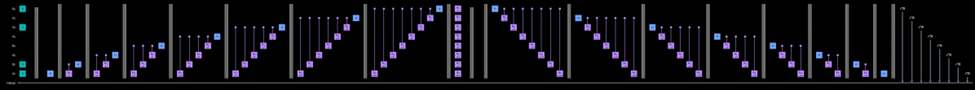

"Transpile Left" shows much better results than "Basic Transpilation":

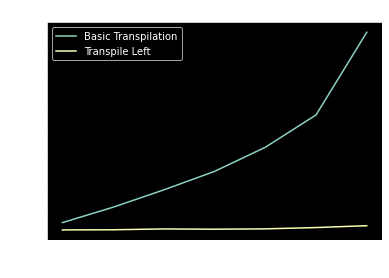